# Booter attack analysis

This is a Jupyter Notebook written for the analysis of generic pcap format files in which there is a DNS-based DDoS attack. If you don't know what is Jupyter Notebook then you must access the documentation (at http://jupyter.org/), learn how to use, install on your own machine, and have fun analysing attacks.

**If you want to do 'this', or 'that', or even 'that other thing' on your analysis or your graphs, believe me: it is possible! GOOGLE IT!**

# Libraries that I use to analyse data

In [14]:
import pandas as pd #more info at http://pandas.pydata.org/
import numpy as np #more info at http://www.numpy.org/
import matplotlib.pyplot as plt #some examples for you at http://matplotlib.org/gallery.html 
from matplotlib import gridspec #more info at http://matplotlib.org/api/gridspec_api.html
import seaborn as sns

plt.style.use('ggplot') #For improving the visualization style (options: grayscale, bmh, dark_background, ggplot, and fivethirtyeight)

#Magic line: to show the plots inline in the Jupyter Notebook
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore') #To avoid showing annoying warns

In [16]:
df = pd.read_csv('real_booter_attack.csv', error_bad_lines=False, sep=';')

# Functions to make your life easier 

In [17]:
def timestamp2datetime(series):
    return  pd.to_datetime(series,unit='s',errors='coerce')

In [18]:
def bytes2bits(series):
    try:
        return  series*8
    except AttributeError:
        return series     

# Using the above functions to convert some columns of the dataframe 

In [19]:
df['frame.time_epoch']=timestamp2datetime(df['frame.time_epoch'])

In [30]:
df['frame.len']=bytes2bits(df['frame.len'])

In [31]:
df.head()

,frame.time_epoch,ip.proto,ip.src,ip.dst,udp.srcport,udp.dstport,tcp.srcport,tcp.dstport,frame.len,dns.qry.type,dns.qry.name,dns.resp.name
0,2014-12-22 15:38:42.525944710,1,162.8.125.17,172.31.28.132,NaN,NaN,NaN,NaN,3968,NaN,NaN,NaN
1,2014-12-22 15:38:42.525982140,1,172.31.28.132,162.8.125.17,NaN,NaN,NaN,NaN,3968,NaN,NaN,NaN
2,2014-12-22 15:38:42.648396015,17,172.31.28.132,172.31.0.2,51139.0,53.0,NaN,NaN,6592,1.0,ip-172-31-28-132.us-west-2.compute.internal,NaN
3,2014-12-22 15:38:42.648422003,17,172.31.28.132,172.31.0.2,51139.0,53.0,NaN,NaN,6592,28.0,ip-172-31-28-132.us-west-2.compute.internal,NaN
4,2014-12-22 15:38:42.648628950,17,172.31.0.2,172.31.28.132,53.0,51139.0,NaN,NaN,10496,28.0,ip-172-31-28-132.us-west-2.compute.internal,us-west-2.compute.internal


# Question 1: How many records are in the entire trace?

In [110]:
df.shape[0]

122233

# Question 2: What is the duration of the entire trace?

In [87]:
diff = df['frame.time_epoch'].iloc[-1] - df['frame.time_epoch'].iloc[0]
print(str(diff))

0 days 00:00:25.343013


# Question 3: Show three packets that are not part of the attack

In [109]:
df[df['ip.proto'] == "1"]

,frame.time_epoch,ip.proto,ip.src,ip.dst,udp.srcport,udp.dstport,tcp.srcport,tcp.dstport,frame.len,dns.qry.type,dns.qry.name,dns.resp.name
0,2014-12-22 15:38:42.525944710,1,162.8.125.17,172.31.28.132,NaN,NaN,NaN,NaN,3968,NaN,NaN,NaN
1,2014-12-22 15:38:42.525982140,1,172.31.28.132,162.8.125.17,NaN,NaN,NaN,NaN,3968,NaN,NaN,NaN
10,2014-12-22 15:38:42.734422922,1,162.8.125.20,172.31.28.132,NaN,NaN,NaN,NaN,3968,NaN,NaN,NaN
11,2014-12-22 15:38:42.734441042,1,172.31.28.132,162.8.125.20,NaN,NaN,NaN,NaN,3968,NaN,NaN,NaN


# Question 4: What are the characteristics of the attack? 

In [102]:
top_target_ip = df['ip.dst'].value_counts().index[0]
top_attacker_src_port = df['udp.srcport'].value_counts().index[0]
top_target_src_port = df['udp.dstport'].value_counts().index[0]
top_dns_type = df['dns.qry.type'].value_counts().index[0]
print('Most common destination IP: %s' % (top_target_ip))
print('Most common destination port: %s' % top_target_src_port)
print('Most common attacker src port: %s' % top_attacker_src_port)
print('Most commont DNS Query Type: %s, better known as ANY' % top_dns_type)

Most common destination IP: 172.31.28.132
Most common destination port: 80.0
Most common attacker src port: 53.0
Most commont DNS Query Type: 255.0, better known as ANY


# Question 5: What does a wireshark filter of the attack look like? 

The most logical would be all trafic going to the victim, which would look like: ip.dst == 172.31.28.132

# Question 6: Which is the target destination ip of the attack?

In [104]:
print('Most common destination IP: %s' % (top_target_ip))

Most common destination IP: 172.31.28.132


# Question 7: How many packets are part of the attack?

In [113]:
df[df['ip.dst'] == top_target_ip].shape[0]

120253

# Question 8: How many source ips were part of the attack?

In [136]:
udp_srcip_dstip_top1=df[df['ip.dst']==top_target_ip]['ip.src']
len(udp_srcip_dstip_top1.unique())

83

# Question 9: Which top 3 source ips sent most packets in the attack? 

In [141]:
udp_srcip_dstip_top1.value_counts().head(3)

37.123.96.179    11126
61.93.9.158       8086
121.32.89.198     6261
Name: ip.src, dtype: int64

## 9.1 Where are the top 3 source ips geolocated?

- 37.123.96.179: Manilla, Turkey
- 61.93.9.158: Hong kong
- 121.32.89.198: Guangzhou, China

## 9.2 Which autonomous systems are related to these top 3 source ips

- 37.123.96.179: AS57844 SPDNet Telekomunikasyon Hizmetleri Bilgi Teknolojileri Taahhut Sanayi Ve Ticaret A.S.
- 61.93.9.158: AS9269 Hong Kong Broadband Network Ltd.
- 121.32.89.198: AS134773 CHINANET Guangdong province Guangzhou MAN network

# 9.3 

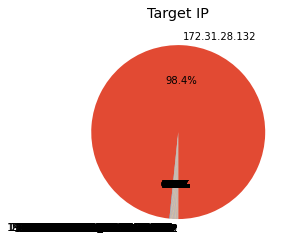

In [50]:
ip_dst=df['ip.dst'].value_counts()
fig = plt.figure(figsize=(4,4))

ax = plt.subplot2grid((1,1), (0,0))
ip_dst.plot(ax=ax,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10,title="Target IP")
ax.set_ylabel("")

fig.show()

## 1.3. Well, the IP that most received packets was ... 

In [49]:
top1_target_ip=ip_dst.index[0]
top1_target_ip

'172.31.28.132'

## 2.1. Which \16 network the target IP bellongs?

In [25]:
target_network=top1_target_ip.split('.')[0]+'.'+top1_target_ip.split('.')[1]
target_network

'172.31'

## 3.1. Which IP protocols occurred more in the trace?

In [51]:
ip_proto=df['ip.proto'].value_counts()
ip_proto.head()

17      120350
1,17      1878
1            4
6            1
Name: ip.proto, dtype: int64

## 3.2. Visualizing the distribution of IP protocols

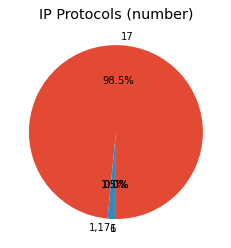

In [52]:
fig = plt.figure(figsize=(4,4))

ax = plt.subplot2grid((1,1), (0,0))
ip_proto.plot(ax=ax,kind='pie', autopct='%1.1f%%', startangle=270, fontsize=10,title="IP Protocols (number)")
ax.set_ylabel("")

fig.show()

## 3.3. Well, the IP protocol that occurred more was... 

In [53]:
top1_target_ip_proto=ip_proto.index[0]
top1_target_ip_proto

'17'

## 4.1. How is the Distribution of UDP ports for the top 1 (or 2) target IP address(es)?

In [55]:
udp_srcip_dstip_top1=df[df['ip.dst']==top1_target_ip]['ip.src'].value_counts()
udp_srcport_top1=df[df['ip.dst']==top1_target_ip]['udp.srcport'].value_counts()
udp_dstport_top1=df[df['ip.dst']==top1_target_ip]['udp.dstport'].value_counts()

# udp_srcip_dstip_top2=df[df['ip.dst']==top2_target_ip]['ip.src'].value_counts()
# udp_srcport_top2=df[df['ip.dst']==top2_target_ip]['udp.srcport'].value_counts()
# udp_dstport_top2=df[df['ip.dst']==top2_target_ip]['udp.dstport'].value_counts()

NameError: name 'top2_target_ip' is not defined

## 4.2. Visualizing the distribution of src IPs and the (src and dst) UDP ports

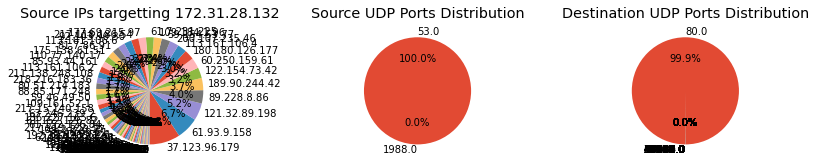

In [56]:
fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(wspace=1)

ax = plt.subplot2grid((2,3), (0,0))
udp_srcip_dstip_top1.plot(kind='pie',ax=ax, autopct='%1.1f%%', startangle=270, fontsize=10,title="Source IPs targetting "+top1_target_ip)
ax.set_ylabel("")

ax1 = plt.subplot2grid((2,3), (0,1))
udp_srcport_top1.plot(kind='pie',ax=ax1, autopct='%1.1f%%', startangle=270, fontsize=10,title="Source UDP Ports Distribution")
ax1.set_ylabel("")

ax2 = plt.subplot2grid((2,3), (0,2))
udp_dstport_top1.plot(kind='pie',ax=ax2, autopct='%1.1f%%', startangle=270, fontsize=10,title="Destination UDP Ports Distribution")
ax2.set_ylabel("")

# ax3 = plt.subplot2grid((2,3), (1,0))
# udp_srcip_dstip_top2.plot(kind='pie',ax=ax3, autopct='%1.1f%%', startangle=270, fontsize=10,title="Source IPs targetting "+top2_target_ip)
# ax3.set_ylabel("")

# ax4 = plt.subplot2grid((2,3), (1,1))
# udp_srcport_top2.plot(kind='pie',ax=ax4, autopct='%1.1f%%', startangle=270, fontsize=10,title="Source UDP Ports Distribution")
# ax4.set_ylabel("")

# ax5 = plt.subplot2grid((2,3), (1,2))
# udp_dstport_top2.plot(kind='pie',ax=ax5, autopct='%1.1f%%', startangle=270, fontsize=10,title="Destination UDP Ports Distribution")
# ax5.set_ylabel("")

fig.show()

<h1 align='center'> !!!!!!!!!!!!!!!!!!!!!!!!<br>
DO THE FOLLOWING ONLY IF THE TOP SRC PORT WAS 53 (DNS)</h1>

## 5.1. What were the DNS queries used in the attack?

In [57]:
occurrence_dnsquery=df['dns.qry.name'].value_counts()
occurrence_dnsquery.head()

bls.gov         24374
nlhosting.nl    17918
sandia.gov      15805
isc.org         12504
verisign.com    10500
Name: dns.qry.name, dtype: int64

## 5.2. Visualizing the distribution of DNS queries

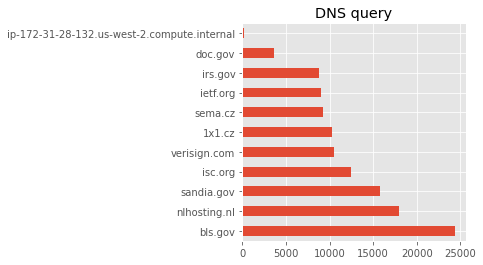

In [58]:
fig = plt.figure(figsize=(4,4))
ax = plt.subplot2grid((1,1), (0,0))
occurrence_dnsquery.plot(kind='barh',ax=ax, fontsize=10, title="DNS query")
ax.set_ylabel("")

fig.show()

## 5.3. Well, considering that only the top 1 DNS query was used in the attack... 

In [59]:
top_dnsquery=occurrence_dnsquery.index[0]
top_dnsquery

'bls.gov'

## 6.1. What was the greatest frame length that the DNS query used on the attack had? (i.e., which generated the greatest amplification factor)

In [60]:
max(df['frame.len'][df['dns.qry.name']==top_dnsquery])

253248

<h1 align='center'> !!!!! 7.1. VERY IMPORTANT !!!!!<br>
Defining ONLY the main attack records<br>(attention to the others commented types of attacks)</h1>

In [126]:
# # MANUAL SELECTION: Considering the attack from ONE to ONE port!!!
# attack_records=df[df['ip.dst']==top1_target_ip]\
#                 [df['ip.src'].str.contains(target_network)==False]\
#                 [df['ip.proto']==top1_target_ip_proto]\
#                 [df['udp.srcport']==udp_srcport_top1.index[0]]\
#                 [df['udp.dstport']==udp_dstport_top1.index[0]]

# # MANUAL SELECTION: Considering the attack from ONE to MANY ports!!!
# attack_records=df[df['ip.dst']==top1_target_ip]\
#                 [df['ip.src'].str.contains(target_network)==False]\
#                 [df['ip.proto']==top1_target_ip_proto]\
#                 [df['udp.srcport']==udp_srcport_top1.index[0]]\
#                 [df['dns.qry.name'].str.contains(top_dnsquery)==True]
                
# # MANUAL SELECTION: Considering the attack from MANY to ONE port!!!
# attack_records=df[df['ip.dst']==top1_target_ip]\
#                 [df['ip.src'].str.contains(target_network)==False]\
#                 [df['ip.proto']==top1_target_ip_proto]\
#                 [df['udp.dstport']==udp_dstport_top1.index[0]]\
#                 [df['dns.qry.name'].str.contains(top_dnsquery)==True]

# MANUAL SELECTION: Considering the attack from MANY to MANY portS!!!
attack_records=df[df['ip.dst']==top1_target_ip]\
                [df['ip.src'].str.contains(target_network)==False]\
                [df['ip.proto']==top1_target_ip_proto]\
                [df['udp.srcport']==udp_srcport_top1.index[0]]\
                [df['udp.dstport']==udp_dstport_top1.index[0]]\
                [df['dns.qry.name'].str.contains(top_dnsquery)==True]

remaining_records=df[~df.isin(attack_records)]


## 8.1. Generating a time series of the attack and the remaining traffic

In [62]:
overall_bps=df.set_index(['frame.time_epoch']).groupby(pd.TimeGrouper(freq='S')).agg(['sum'])['frame.len']
attack_bps=attack_records.set_index(['frame.time_epoch']).groupby(pd.TimeGrouper(freq='S')).agg(['sum'])['frame.len']
attack_bps_median=attack_bps.median()
attack_bps_peak=max(attack_bps['sum'])

remaining_bps=remaining_records.set_index(['frame.time_epoch']).groupby(pd.TimeGrouper(freq='S')).agg(['sum'])['frame.len']

AttributeError: module 'pandas' has no attribute 'TimeGrouper'

## 8.2. Visualizing the time series 

NameError: name 'attack_bps' is not defined

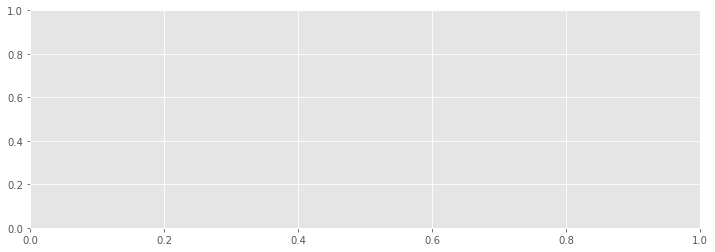

In [63]:
fig = plt.figure(figsize=(12,4))

ax = plt.subplot2grid((1,1), (0,0))

attack_bps.plot(ax=ax, lw=1)
ax.fill_between(attack_bps.index, 0, attack_bps['sum'],color='r')

ax.annotate(str(attack_bps_peak/10e5)+' Mb/s [peak]', (str(attack_bps[attack_bps['sum'] == attack_bps_peak].index.values[0]), attack_bps_peak),
             xytext=(0, 0), textcoords='offset points')
ax.annotate(str(attack_bps_median[0]/10e5)+' Mb/s [median]', (str(attack_bps.index.values[0]), attack_bps_median),
             xytext=(90, 0), textcoords='offset points')

remaining_bps.plot(ax=ax)

ax.legend(['Attacks records','Remaining records'])
ax.set_ylabel("Data [bit]")
ax.set_xlabel("Time [second]")

fig.show()

## 9.1. How many records in the entire trace, attack records, and remaining records? 

In [66]:
print ('Records:', len(df),'records (100%),',len(attack_records),'attack records (',len(attack_records)*100/len(df),'%)',',', len(df)-len(attack_records),'remaining records (',(len(df)-len(attack_records))*100/len(df),'% )')

Records: 122233 records (100%), 120149 attack records ( 98.29505943566795 %) , 2084 remaining records ( 1.7049405643320543 % )


## 10.1. What is the duration of the entire trace and the attack part? 

In [67]:
print ('Trace duration:',max(df['frame.time_epoch'])-min(df['frame.time_epoch']))
print ('Attack duration:',max(attack_records['frame.time_epoch'])-min(attack_records['frame.time_epoch']))

Trace duration: 0 days 00:00:25.343013
Attack duration: 0 days 00:00:20.156359


## 11.1. How many (source) IPs were involved in the attack?

In [132]:
len(attack_records['ip.src'].unique())

48

## 12.1. What are the top 5 IP addresses that sent more packets?

In [69]:
top5_srcips_pkts=attack_records['ip.src'].value_counts().head(5).sort_values()
top5_srcips_pkts

189.90.244.42     4433
89.228.8.86       4831
121.32.89.198     6261
61.93.9.158       8086
37.123.96.179    11126
Name: ip.src, dtype: int64

## 12.2. Visualizing the top 5 IP addresses that sent more packets

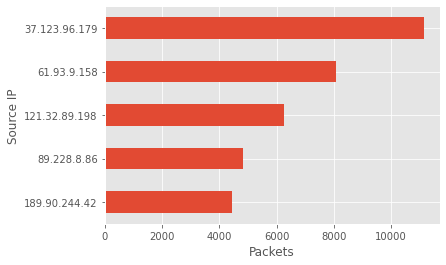

In [70]:
fig = plt.figure()
ax = plt.subplot2grid((1,1), (0,0))
top5_srcips_pkts.plot(kind='barh')
ax.set_ylabel("Source IP")
ax.set_xlabel("Packets")

fig.show()

## 13.1. What are the top 5 IP addresses that sent more attack data?

In [71]:
top5_srcips_bits=attack_records.groupby('ip.src').agg(['sum'])['frame.len'].sort_values('sum',ascending=False).head(5).sort_values('sum', ascending=False)
top5_srcips_bits

,sum
ip.src,
37.123.96.179,2322210816
61.93.9.158,1570724352
121.32.89.198,916787200
189.90.244.42,852264896
60.250.159.61,713143552


## 13.2. Visualizing the top 5 IP addresses that sent more attack data

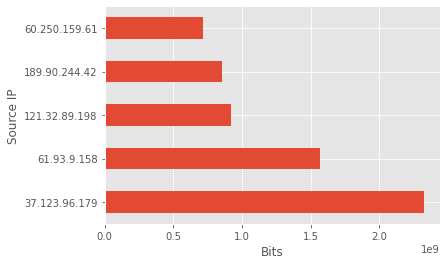

In [72]:
fig = plt.figure()
ax = plt.subplot2grid((1,1), (0,0))
top5_srcips_bits.plot(kind='barh',ax=ax,legend=False)
ax.set_ylabel("Source IP")
ax.set_xlabel("Bits")

fig.show()

## 13.3. Well, the top 1 Source IP was ...

In [73]:
top1_srcips_bits = top5_srcips_bits.index[0]
top1_srcips_bits 

'37.123.96.179'

## 14.1. In which country the top 1 source IP address is located?

In [75]:
import subprocess
p = subprocess.Popen(['whois', '-h', 'whois.cymru.com','\"', '-v',top1_srcips_bits,'\"' ], stdout=subprocess.PIPE)

print (p.communicate()[0])

FileNotFoundError: [WinError 2] Het systeem kan het opgegeven bestand niet vinden